In [1]:
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from pandas import Series
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
import pandas as pd
from math import sqrt
from sklearn.metrics import mean_squared_error
import warnings
import time

C:\Users\admin\AppData\Local\Temp\ipykernel_21168\4168655567.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [2]:
df_2=pd.read_csv('catfish.csv')

In [3]:
df_2['Date'] = pd.to_datetime(df_2['Date'])


In [4]:
df_2.set_index('Date', inplace=True)

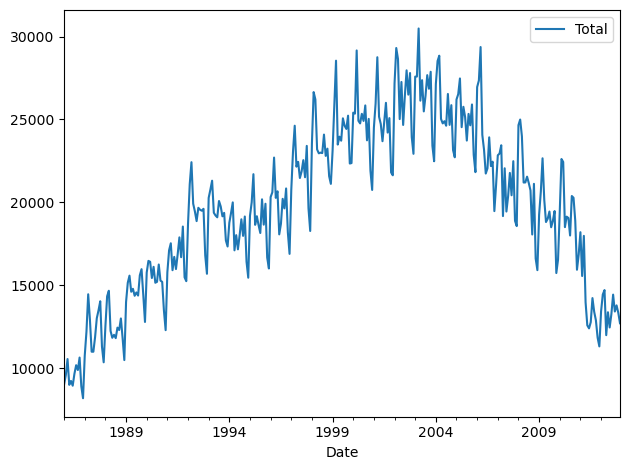

In [5]:
df_2['Total'].plot(legend=True)
plt.tight_layout()
plt.show()


In [59]:
df_2

,Total
Date,
1986-01-01,9034
1986-02-01,9596
1986-03-01,10558
1986-04-01,9002
1986-05-01,9239
...,...
2012-08-01,14442
2012-09-01,13422
2012-10-01,13795


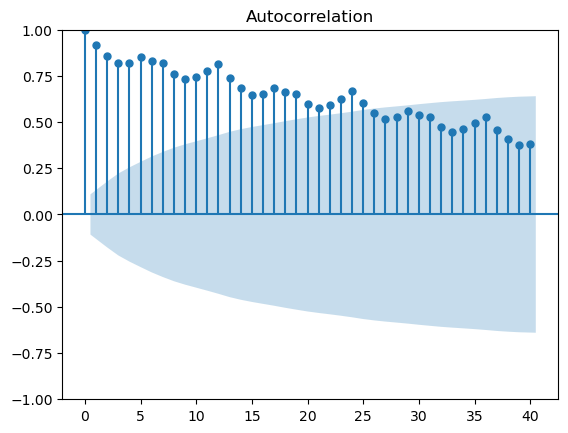

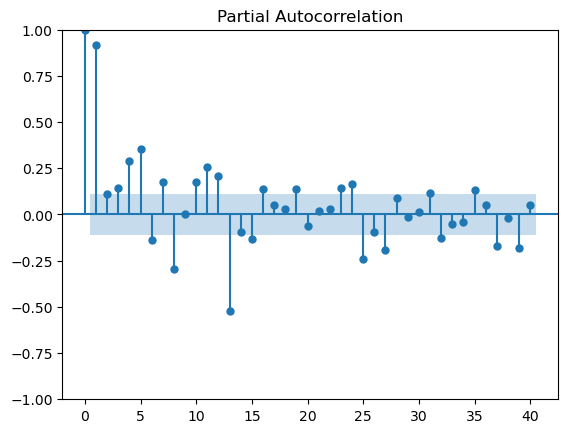

In [60]:
plot_acf(df_2['Total'],lags=40)
plot_pacf(df_2['Total'], lags=40)
plt.show()

In [61]:
# train_size = int(len(df_2) * 0.8)  # 80% of data for training
# train_data_2, test_data_2 = df_2[:train_size], df_2[train_size:]

In [13]:
train_size = int(len(df_2) * 0.80)
train_data_2, test_data_2 = df_2[0:train_size], df_2[train_size:]
 

In [16]:
start_2=len(train_data_2)
end_2=len(train_data_2)+ len(test_data_2)-1

In [75]:
model_4=ARIMA(train_data_2,order=(1,0,1))
model_4=model_4.fit()
model_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Total   No. Observations:                  259
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -2318.444
Date:                Thu, 11 Apr 2024   AIC                           4644.888
Time:                        17:13:53   BIC                           4659.115
Sample:                    01-01-1986   HQIC                          4650.608
                         - 07-01-2007                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.016e+04   5432.586      3.711      0.000    9513.125    3.08e+04
ar.L1          0.9963      0.006    177.200      0.000       0.985       1.007
ma.L1         -0.7030      0.046    -15.245      0.000      -0.793      -0.613
sigma2      3.445e+06     20.054   1.72e+05      0.000    3.45e+06    3.45e+06
===================================================================================
Ljung-Box (L1) (Q):                  20.16   Jarque-Bera (JB):                 4.52
Prob(Q):                              0.00   Prob(JB):                         0.10
Heteroskedasticity (H):               1.80   Skew:                             0.32
Prob(H) (two-sided):                  0.01   Kurtosis:                         2.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.94e+20. Standard errors may be unstable.
"""

In [76]:
pred_4=model_4.predict(start=start_2,end=end_2,type='levels')

In [77]:
pred_4.index=df_2.index[start_2:end_2+1]

<AxesSubplot:xlabel='Date'>

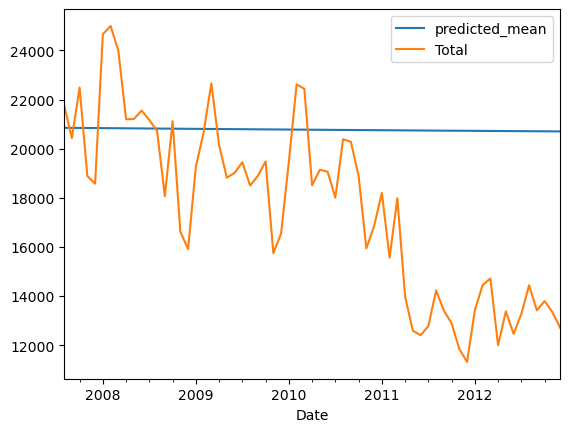

In [78]:
pred_4.plot(legend=True)
test_data_2['Total'].plot(legend=True)

In [79]:
start_2

259

In [80]:
end_2

323

In [81]:
len(pred_4)

65

In [82]:
from sklearn.metrics import mean_absolute_error

In [83]:
mae=mean_absolute_error(pred_4,test_data_2['Total'])
print(mae)

3844.5020255562354


# Grid Search

In [19]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller

def check_stationarity(series, max_diff_order=2, alpha=0.05):
    """
    Check stationarity of a time series using the Augmented Dickey-Fuller (ADF) test.
    If the series is not stationary, apply differencing recursively until stationarity is achieved.
    
    Parameters:
    - series: pandas Series, the time series data
    - max_diff_order: int, maximum order of differencing to be applied (default: 2)
    - alpha: float, significance level for ADF test (default: 0.05)
    
    Returns:
    - stationary_series: pandas Series, the stationary time series
    """
    # Perform ADF test
    adf_result = adfuller(series)
    p_value = adf_result[1]
    
    # If the series is already stationary, return the original series
    if p_value < alpha:
        print("Original series is stationary (p-value: {:.4f})".format(p_value))
        return series
    
    
    
    # If the series is not stationary, apply differencing
    print("Original series is not stationary (p-value: {:.4f}), applying differencing...".format(p_value))
    for diff_order in range(1, max_diff_order + 1):
        differenced_series = series.diff(diff_order).dropna()
        adf_result_diff = adfuller(differenced_series)
        p_value_diff = adf_result_diff[1]
        
        # Check stationarity after differencing
        if p_value_diff < alpha:
            print("Series after {} order differencing is stationary (p-value: {:.4f})".format(diff_order, p_value_diff))
            return differenced_series
        
    # If maximum differencing orders reached and still not stationary, return None
    print("Maximum differencing orders reached. Unable to achieve stationarity.")
    return None

# Example usage:
# Assuming 'time_series' is your pandas Series containing the time series data
# stationary_series = check_stationarity(time_series)


In [7]:
def difference(dataset, interval=1):
 diff = list()
 for i in range(interval, len(dataset)):
     value = dataset[i] - dataset[i - interval]
     diff.append(value)
 return Series(diff)

In [21]:
stat=check_stationarity(df_2['Total'])

Original series is not stationary (p-value: 0.4887), applying differencing...
Series after 1 order differencing is stationary (p-value: 0.0004)


In [38]:
def evaluate_arima_model(X, arima_order):
 # prepare training dataset
 train_size = int(len(X) * 0.80)
 train, test = X[0:train_size], X[train_size:]
 history = [x for x in train]
 predictions = list()
 for t in range(len(test)):
     model = ARIMA(history, order=arima_order)
     model_fit = model.fit()
     yhat = model_fit.forecast()[0]
     predictions.append(yhat)
     history.append(test[t])
 # # calculate out of sample error
 rmse = sqrt(mean_squared_error(test, predictions))
 return rmse,predictions



In [42]:
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse,predictions = evaluate_arima_model(dataset, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))
    return predictions



In [43]:
%%time
p_values = range(0,3)
d_values = range(0,3)
q_values = range(0,3)
warnings.filterwarnings("ignore")
predictions_f=evaluate_models(df_2['Total'], p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=4291.542
ARIMA(0, 0, 1) RMSE=2752.009
ARIMA(0, 0, 2) RMSE=2667.482
ARIMA(0, 1, 0) RMSE=1981.805
ARIMA(0, 1, 1) RMSE=1957.827
ARIMA(0, 1, 2) RMSE=1842.939
ARIMA(0, 2, 0) RMSE=2997.527
ARIMA(0, 2, 1) RMSE=1989.022
ARIMA(0, 2, 2) RMSE=2033.408
ARIMA(1, 0, 0) RMSE=1950.944
ARIMA(1, 0, 1) RMSE=1967.729
ARIMA(1, 0, 2) RMSE=1853.136
ARIMA(1, 1, 0) RMSE=1964.315
ARIMA(1, 1, 1) RMSE=1860.605
ARIMA(1, 1, 2) RMSE=1845.212
ARIMA(1, 2, 0) RMSE=2672.917
ARIMA(1, 2, 1) RMSE=1972.648
ARIMA(1, 2, 2) RMSE=1971.875
ARIMA(2, 0, 0) RMSE=1944.413
ARIMA(2, 0, 1) RMSE=1871.059
ARIMA(2, 0, 2) RMSE=1847.516
ARIMA(2, 1, 0) RMSE=1912.153
ARIMA(2, 1, 1) RMSE=1840.219
ARIMA(2, 1, 2) RMSE=1933.125
ARIMA(2, 2, 0) RMSE=2499.561
ARIMA(2, 2, 1) RMSE=1920.844
ARIMA(2, 2, 2) RMSE=1903.637
Best ARIMA(2, 1, 1) RMSE=1840.219
Wall time: 12min 17s


# AutoARIMA

In [143]:
stepwise_fit_2=auto_arima(train_data_2,start_p=0, start_q=0,d=1,
                           max_p=40, max_q=40,information_criterion='bic',trace=True,suppress_warnings=True,stepwise=True,seasonal=False)
stepwise_fit_2.summary()

Performing stepwise search to minimize bic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : BIC=4649.232, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : BIC=4649.084, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : BIC=4638.067, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : BIC=4643.814, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : BIC=4607.085, Time=1.22 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : BIC=4602.170, Time=0.89 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : BIC=4649.248, Time=0.17 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : BIC=4583.298, Time=0.99 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : BIC=4612.777, Time=0.29 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : BIC=4559.523, Time=0.87 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : BIC=4568.196, Time=0.33 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : BIC=4564.788, Time=1.22 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : BIC=inf, Time=2.02 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : BIC=4542.279, Time=1.88 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : 

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  259
Model:               SARIMAX(4, 1, 3)   Log Likelihood               -2231.495
Date:                Thu, 11 Apr 2024   AIC                           4478.991
Time:                        17:30:24   BIC                           4507.414
Sample:                    01-01-1986   HQIC                          4490.420
                         - 07-01-2007                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0314      0.083    -12.425      0.000      -1.194      -0.869
ar.L2         -0.3177      0.146     -2.172      0.030      -0.604      -0.031
ar.L3         -0.2222      0.135     -1.650      0.099      -0.486       0.042
ar.L4         -0.5289      0.071     -7.496      0.000      -0.667      -0.391
ma.L1          0.9692      0.091     10.632      0.000       0.791       1.148
ma.L2         -0.2427      0.151     -1.607      0.108      -0.539       0.053
ma.L3         -0.6655      0.096     -6.966      0.000      -0.853      -0.478
sigma2      2.131e+06   1.17e-08   1.82e+14      0.000    2.13e+06    2.13e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.73   Jarque-Bera (JB):                 3.49
Prob(Q):                              0.39   Prob(JB):                         0.17
Heteroskedasticity (H):               1.42   Skew:                             0.27
Prob(H) (two-sided):                  0.11   Kurtosis:                         2.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.01e+30. Standard errors may be unstable.
"""

In [149]:
model_3=ARIMA(train_data_2,order=(4,1,3))
model_3=model_3.fit()
model_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Total   No. Observations:                  259
Model:                 ARIMA(4, 1, 3)   Log Likelihood               -2231.495
Date:                Thu, 11 Apr 2024   AIC                           4478.991
Time:                        17:30:48   BIC                           4507.414
Sample:                    01-01-1986   HQIC                          4490.420
                         - 07-01-2007                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0314      0.083    -12.425      0.000      -1.194      -0.869
ar.L2         -0.3177      0.146     -2.172      0.030      -0.604      -0.031
ar.L3         -0.2222      0.135     -1.650      0.099      -0.486       0.042
ar.L4         -0.5289      0.071     -7.496      0.000      -0.667      -0.391
ma.L1          0.9692      0.091     10.632      0.000       0.791       1.148
ma.L2         -0.2427      0.151     -1.607      0.108      -0.539       0.053
ma.L3         -0.6655      0.096     -6.966      0.000      -0.853      -0.478
sigma2      2.131e+06   1.17e-08   1.82e+14      0.000    2.13e+06    2.13e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.73   Jarque-Bera (JB):                 3.49
Prob(Q):                              0.39   Prob(JB):                         0.17
Heteroskedasticity (H):               1.42   Skew:                             0.27
Prob(H) (two-sided):                  0.11   Kurtosis:                         2.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.01e+30. Standard errors may be unstable.
"""

In [150]:
pred_3=model_3.predict(start=start_2,end=end_2,type='levels')

In [151]:
pred_3

2007-08-01    22583.705825
2007-09-01    20998.738739
2007-10-01    22474.157933
2007-11-01    20475.513442
2007-12-01    21253.887336
                  ...     
2012-08-01    21961.444962
2012-09-01    20463.202999
2012-10-01    22195.348839
2012-11-01    20690.770801
2012-12-01    21568.544636
Freq: MS, Name: predicted_mean, Length: 65, dtype: float64

In [152]:
pred_3.index=df_2.index[start_2:end_2+1]

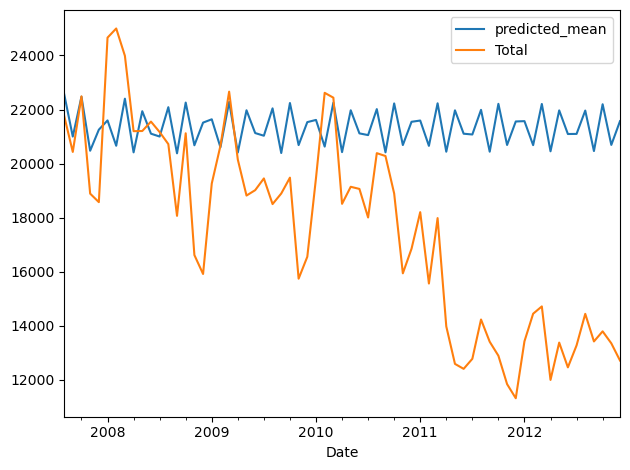

In [153]:
pred_3.plot(legend=True)
test_data_2['Total'].plot(legend=True)
plt.tight_layout()

In [154]:
from sklearn.metrics import mean_absolute_error


In [155]:
rmse=sqrt(mean_squared_error(pred_3,test_data_2['Total']))
print(rmse)

5182.3857125716895


In [156]:
test_data_2['Total'].mean()

17581.33846153846

In [171]:
model_future=ARIMA(df_2['Total'],order=(4,1,3))
model_future=model_future.fit()

In [172]:
df_2.tail()

,Total
Date,
2012-08-01,14442
2012-09-01,13422
2012-10-01,13795
2012-11-01,13352
2012-12-01,12716


In [173]:
index_future=pd.date_range(start='2012-12-01',end='2013-08-01',freq='M')

In [174]:
index_future

DatetimeIndex(['2012-12-31', '2013-01-31', '2013-02-28', '2013-03-31',
               '2013-04-30', '2013-05-31', '2013-06-30', '2013-07-31'],
              dtype='datetime64[ns]', freq='M')

In [175]:
pred_future=model_future.predict(start=len(df_2),end=len(df_2)+7,type='level')

In [176]:
pred_future

2013-01-01    12890.779787
2013-02-01    12496.338173
2013-03-01    14025.183841
2013-04-01    12807.928371
2013-05-01    13561.898901
2013-06-01    13067.103273
2013-07-01    12820.784027
2013-08-01    13709.824438
Freq: MS, Name: predicted_mean, dtype: float64

In [177]:
pred_future.index=index_future

In [178]:
pred_future

2012-12-31    12890.779787
2013-01-31    12496.338173
2013-02-28    14025.183841
2013-03-31    12807.928371
2013-04-30    13561.898901
2013-05-31    13067.103273
2013-06-30    12820.784027
2013-07-31    13709.824438
Freq: M, Name: predicted_mean, dtype: float64

In [179]:
len(df_2)

324

<AxesSubplot:>

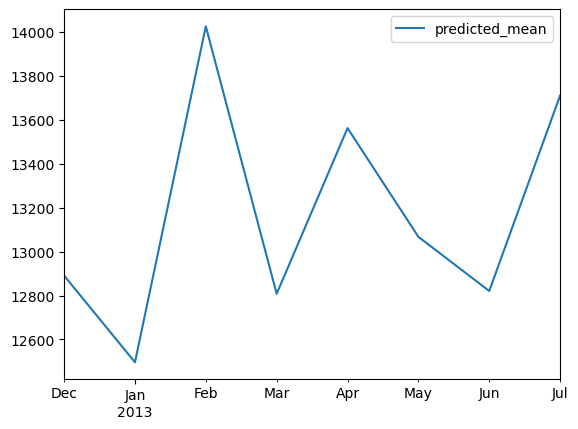

In [180]:
pred_future.plot(legend=True)

In [181]:
df_final=pd.DataFrame({'Date':pred_future.index, 'Total':pred_future.values})

In [182]:
df_final['Date'] = pd.to_datetime(df_final['Date'])

In [183]:
df_final.set_index('Date', inplace=True)

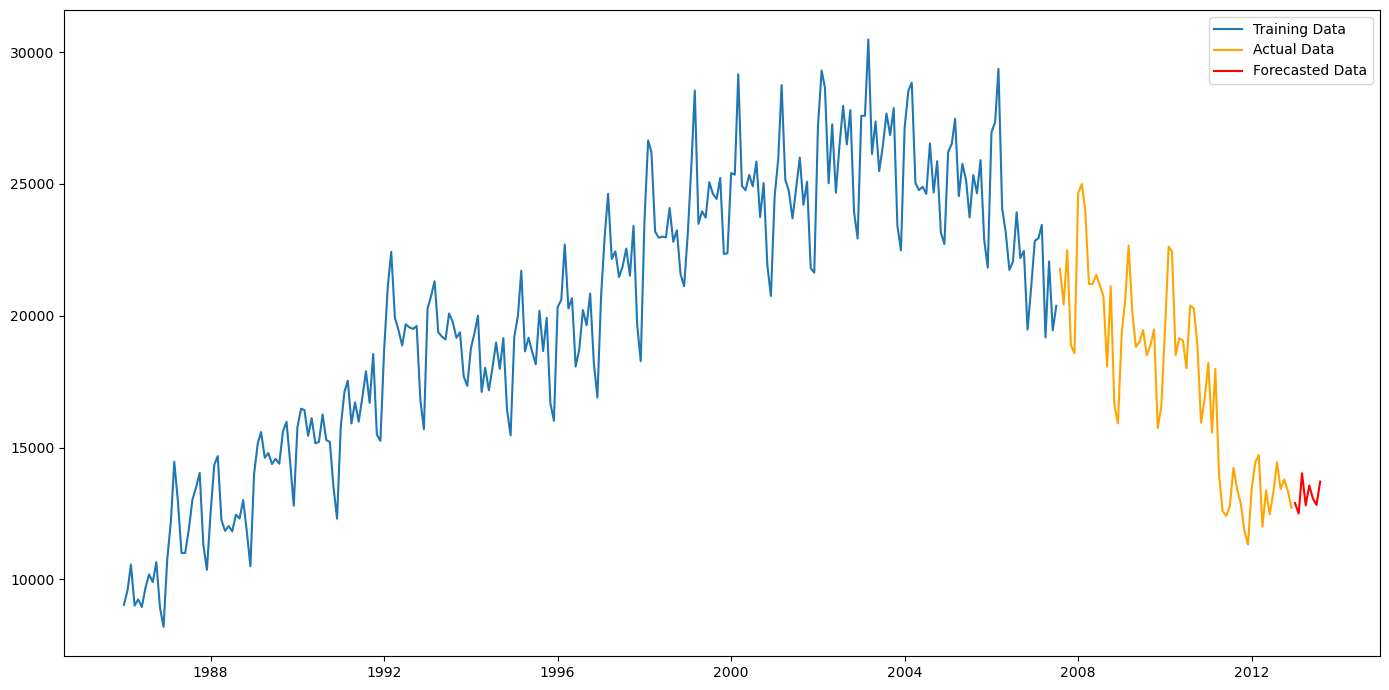

In [184]:
plt.figure(figsize=(14,7))
plt.plot(train_data_2.index,train_data_2['Total'],label='Training Data')
plt.plot(test_data_2.index,test_data_2['Total'], label='Actual Data', color='orange')
plt.plot(df_final.index ,df_final['Total'],label='Forecasted Data', color='red')

plt.legend()
plt.tight_layout()
plt.show()


# Difference the series then apply auto_arima

In [8]:
cat_df=difference(df_2['Total'])

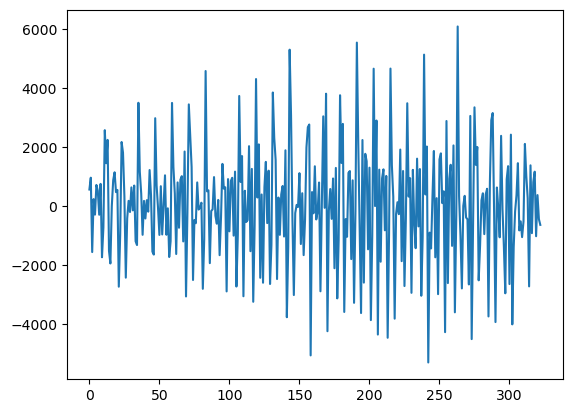

In [9]:
plt.plot(cat_df)

In [10]:
train_size = int(len(df_2) * 0.80)
train_data_3, test_data_3 = cat_df[0:train_size], cat_df[train_size:]


In [11]:
stepwise_fit_3=auto_arima(train_data_3,start_p=0, start_q=0,d=0,
                           max_p=40, max_q=40,information_criterion='aic',trace=True,suppress_warnings=True,stepwise=True,seasonal=False)
stepwise_fit_3.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=4657.758, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=4653.615, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=4637.895, Time=0.19 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=4606.420, Time=0.30 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=4598.007, Time=0.17 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=4649.109, Time=0.07 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=4578.197, Time=0.19 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=4610.342, Time=0.13 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=4544.511, Time=0.40 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=4558.191, Time=0.14 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=4546.120, Time=0.62 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=inf, Time=1.60 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=0.96 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=4558.342, Time=0.17 sec
 ARIMA(5,0,2)(0,0,0)[0]             : AIC=4

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  259
Model:              SARIMAX(12, 0, 1)   Log Likelihood               -2154.805
Date:                Sun, 28 Apr 2024   AIC                           4337.610
Time:                        13:05:52   BIC                           4387.406
Sample:                             0   HQIC                          4357.631
                                - 259                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0683      0.062      1.102      0.271      -0.053       0.190
ar.L2         -0.1018      0.057     -1.772      0.076      -0.214       0.011
ar.L3         -0.1159      0.062     -1.862      0.063      -0.238       0.006
ar.L4         -0.0323      0.058     -0.555      0.579      -0.146       0.082
ar.L5          0.0290      0.058      0.499      0.618      -0.085       0.143
ar.L6         -0.1215      0.057     -2.123      0.034      -0.234      -0.009
ar.L7          0.0672      0.067      1.005      0.315      -0.064       0.198
ar.L8         -0.0882      0.059     -1.500      0.134      -0.203       0.027
ar.L9         -0.0625      0.056     -1.112      0.266      -0.173       0.048
ar.L10        -0.0044      0.055     -0.081      0.935      -0.112       0.103
ar.L11         0.0053      0.057      0.091      0.927      -0.107       0.118
ar.L12         0.6785      0.050     13.684      0.000       0.581       0.776
ma.L1         -0.4836      0.084     -5.743      0.000      -0.649      -0.319
sigma2      1.029e+06   1.04e+05      9.937      0.000    8.26e+05    1.23e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):                 1.77
Prob(Q):                              0.81   Prob(JB):                         0.41
Heteroskedasticity (H):               1.66   Skew:                             0.20
Prob(H) (two-sided):                  0.02   Kurtosis:                         2.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [19]:
model_4=ARIMA(train_data_2,order=(12,1,1))
model_4=model_4.fit()
model_4.summary()

C:\Users\admin\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\admin\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\admin\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\admin\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Total   No. Observations:                  259
Model:                ARIMA(12, 1, 1)   Log Likelihood               -2148.718
Date:                Sun, 28 Apr 2024   AIC                           4325.437
Time:                        13:09:27   BIC                           4375.178
Sample:                    01-01-1986   HQIC                          4345.438
                         - 07-01-2007                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0985      0.058      1.688      0.091      -0.016       0.213
ar.L2         -0.0786      0.051     -1.542      0.123      -0.178       0.021
ar.L3         -0.0953      0.056     -1.707      0.088      -0.205       0.014
ar.L4         -0.0035      0.055     -0.063      0.950      -0.111       0.104
ar.L5          0.0493      0.052      0.950      0.342      -0.052       0.151
ar.L6         -0.1077      0.047     -2.270      0.023      -0.201      -0.015
ar.L7          0.0883      0.058      1.524      0.127      -0.025       0.202
ar.L8         -0.0740      0.054     -1.363      0.173      -0.181       0.032
ar.L9         -0.0404      0.050     -0.815      0.415      -0.137       0.057
ar.L10         0.0123      0.051      0.241      0.810      -0.088       0.112
ar.L11         0.0190      0.053      0.357      0.721      -0.085       0.124
ar.L12         0.6723      0.046     14.483      0.000       0.581       0.763
ma.L1         -0.5195      0.079     -6.574      0.000      -0.674      -0.365
sigma2      1.032e+06   1.04e+05      9.962      0.000    8.29e+05    1.23e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 1.97
Prob(Q):                              0.86   Prob(JB):                         0.37
Heteroskedasticity (H):               1.57   Skew:                             0.21
Prob(H) (two-sided):                  0.04   Kurtosis:                         2.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [20]:
pred_4=model_4.predict(start=start_2,end=end_2,type='levels')

In [21]:
rmse=sqrt(mean_squared_error(pred_4,test_data_2['Total']))
print(rmse)

3071.250790163197


In [22]:
pred_4

2007-08-01    21588.198655
2007-09-01    20224.190693
2007-10-01    20625.573280
2007-11-01    17843.487171
2007-12-01    19638.220626
                  ...     
2012-08-01    18422.307635
2012-09-01    17793.096890
2012-10-01    17898.641652
2012-11-01    16852.822362
2012-12-01    17794.567820
Freq: MS, Name: predicted_mean, Length: 65, dtype: float64